# Sea ice prediction notebook

Date: 09/12/2017  
Author: Alek Petty  

Description: Notebook for sea ice prediction experimentation  
Based on the get_multivar_forcast_months_exp.py script.

Notes: 
This only generates forecasts for one year (of your choosing). The Python script is set up as a loop calling a function to produce forecasts for a series of years. This is needed to produce the lineplots of all the different forecasts and to produce an assessment of forecast skill. This Notebook is more to demonstrate and experiment with the forecast model


In [2]:
# Import Python libraries
%matplotlib inline

#import matplotlib
#matplotlib.use("AGG")

import sys
sys.path.append('../')
import forecast_funcs as ff
from pylab import *
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [42]:
# Options needed to run this Script

plotSkill=1 # for plotting the skill
outSkill=1 # far saving the skill values
outLine=1 # for saving the forecast time series
outWeights=1 #for saving the weightings

startYearF=1980 # Start year of forecast training
numYearsReq=5 #number of years required in a grid cell for it to count towards the training data

yearF=2016 # Forecast data year
yearP=2016 # Predicted year

fmonth=6 #6=June, 9=Sep #  Forecast month
pmonth=9 #9=SEP # Predicted month
fvars=['conc'] # Sea ice concentration='conc'. 
concVersion='' #version of the gridded ice conc files
siiVersion='v3.0'
# Can add multiple variables here, e.g. 'melt'= melt onset over sea ice
weight=1 # Spatially weighting the data, normally 1
hemStr='N' # Hemipshere (N or S)
iceType='extent' # ice type being forecast ('extent' or 'area')
alg=0

region=0
#0 implies pan-Arctic or Antarctic
#2 Weddell Sea
#3 Indian Ocean
#4 Pacific Ocean
#5 Ross Sea
#6 Amundsen/BHausen Sea
#A Alaskan

anomObs=1 # This flag means we have observed data for the forecast year.
# This needs to be set to zero if producing forecasts into the future.


In [31]:
# Figure paths
rawDataPath = '../../Data/' 
derivedDataPath = '../../DataOutput/'



In [32]:
# Get the training data for all years prior to the given forecast year
yearsTr, extentTr = ff.get_ice_extentN(rawDataPath, pmonth, startYearF, yearP-1, icetype=iceType, version=siiVersion, hemStr=hemStr)
# Linearly detrend the data
# NB THIS IS SOMETHING WE CAN LOOK INTO CHANGING
extentDTr, lineTr=ff.get_varDT(yearsTr, extentTr)
print (extentTr, extentDTr)

[7.67 7.14 7.3  7.39 6.81 6.7  7.41 7.28 7.37 7.01 6.14 6.47 7.47 6.4
 7.14 6.08 7.58 6.69 6.54 6.12 6.25 6.73 5.83 6.12 5.98 5.5  5.86 4.27
 4.69 5.26 4.87 4.56 3.57 5.21 5.22 4.62] [-0.0560961  -0.49896997 -0.25184384 -0.07471772 -0.56759159 -0.59046547
  0.20666066  0.16378679  0.34091291  0.06803904 -0.71483483 -0.29770871
  0.78941742 -0.19345646  0.63366967 -0.3392042   1.24792192  0.44504805
  0.38217417  0.0493003   0.26642643  0.83355255  0.02067868  0.3978048
  0.34493093 -0.04794294  0.39918318 -1.10369069 -0.59656456  0.06056156
 -0.24231231 -0.46518619 -1.36806006  0.35906607  0.45619219 -0.05668168]


In [33]:
# Generate the forecast model!
# THIS IS THE MAIN PART OF THE MODEL THAT CAN LIKELY BE IMPROVED.

# Need to get an array filled with ones to act as the intercept
predVarsTYr=[1]
predVars=np.ones((size(yearsTr)))

# Get forecast years
# Normally same as yearsTr but in case crossing year I added this to main script
#yearsFr=np.arange(startYearF, yearF, 1)

for varT in fvars:
    #print 'Var:', varT
    if (varT in ['sst','conc','melt','melt_nan', 'pmas']):

        # Get the gridded forecast data for training (prior to forecast year)
        VarYearsTr = ff.get_gridvar(derivedDataPath, varT, fmonth, yearsTr, hemStr)

        # Get the gridded data of the forecast year
        VarYear = ff.get_gridvar(derivedDataPath, varT, fmonth, array(yearF), hemStr)

        # Weight the gridded forecast data with training/historical sea ice data
        rvalsDT, unweightedPredVarT, predVarT, predVarTYr = ff.GetWeightedPredVar(derivedDataPath, yearsTr, yearF, extentDTr, VarYearsTr, VarYear,varT, fmonth, pmonth, startYearF,numYearsReq, region, hemStr, iceType, normalize=0, outWeights=outWeights, weight=weight)

    # will be an array of 1 (intercept) and a number
    predVarsTYr.append(predVarTYr)
    # will be an array of 1s (intercepts) and a series of numbers
    predVars=np.column_stack((predVars, array(predVarT)))


In [34]:
predVars

array([[ 1.00000000e+00, -1.76312132e-03],
       [ 1.00000000e+00, -2.76456524e-03],
       [ 1.00000000e+00, -5.35255269e-05],
       [ 1.00000000e+00,  2.39462160e-05],
       [ 1.00000000e+00,  3.59022283e-05],
       [ 1.00000000e+00, -2.11090155e-03],
       [ 1.00000000e+00,  4.47278391e-04],
       [ 1.00000000e+00,  9.79539665e-04],
       [ 1.00000000e+00,  2.63573945e-05],
       [ 1.00000000e+00,  2.36903674e-03],
       [ 1.00000000e+00, -3.40017648e-03],
       [ 1.00000000e+00,  8.16470062e-05],
       [ 1.00000000e+00,  2.78765065e-03],
       [ 1.00000000e+00, -2.58218101e-03],
       [ 1.00000000e+00,  2.87391165e-03],
       [ 1.00000000e+00, -3.76902048e-03],
       [ 1.00000000e+00,  5.03705995e-03],
       [ 1.00000000e+00,  5.34321322e-04],
       [ 1.00000000e+00, -1.37306491e-04],
       [ 1.00000000e+00,  2.66669769e-03],
       [ 1.00000000e+00,  1.68326974e-04],
       [ 1.00000000e+00,  3.54204161e-03],
       [ 1.00000000e+00,  1.40332032e-03],
       [ 1.

In [46]:
# Use SM to generate the regression model. Could have just used linregress (tested, gave same results, but this was just a bit neater)
model=sm.OLS(extentDTr, predVars)
fit=model.fit()

# Forecast detrended sea ice extent!
extentForrDT = fit.predict(predVarsTYr)[0]

# Prediction uncertainty estimate
prstd, iv_l, iv_u = wls_prediction_std(fit, exog=predVarsTYr)

# Calculate alternative ice extent forecast simply assuming linear trend persistnce
extTrendP=(lineTr[-1]+(lineTr[-1]-lineTr[-2]))

extentForrAbs = extentForrDT+extTrendP

if (anomObs==1):
    # Get the extent data for the given prediction year and compare against forecast
    years, extentYrs = ff.get_ice_extentN(rawDataPath, pmonth, startYearF, yearP, icetype=iceType, version=siiVersion, hemStr=hemStr)

    #yearsYr, extentYr = ff.getIceExtentAreaPetty(extdatapath, pmonth, startYearF, yearP, icetype=iceType, alg=0)
    extentObsDT=extentYr[-1]-extTrendP
    anom=extentYr-extentForrAbs
    print ('Observed extent:',extentYr[-1])

print ('Linear trend extent:',extTrendP)
print ('Forecast extent:',extentForrAbs)


Observed extent: 4.51
Linear trend extent: 4.589555555555563
Forecast extent: 3.9978023808155037


In [37]:
yearsFr=np.arange(startYearF, yearF, 1)
print (yearsFr)

[1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015]


In [39]:
print (predVarTYr.shape)

()


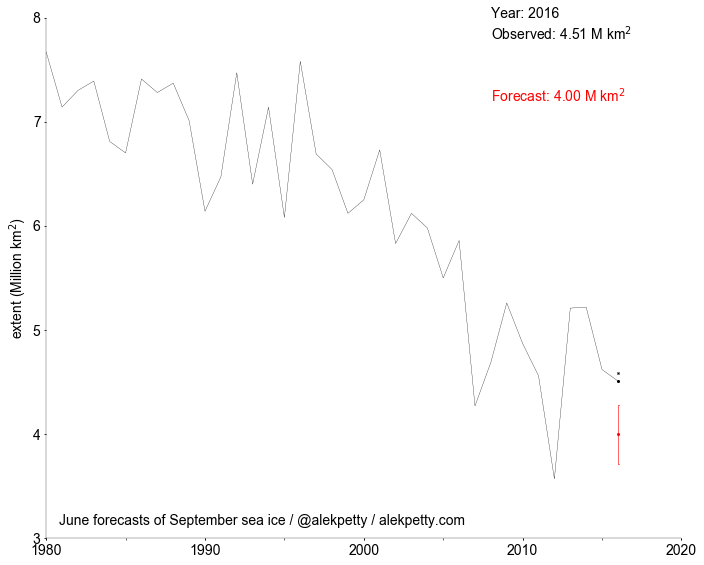

In [55]:
"""Plot forecast data """
from mpl_toolkits.basemap import Basemap, shiftgrid
# plotting parameters
rcParams['xtick.major.size'] = 2
rcParams['ytick.major.size'] = 2
rcParams['axes.linewidth'] = .3
rcParams['lines.linewidth'] = .3
rcParams['patch.linewidth'] = .3

rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize']=14
rcParams['ytick.labelsize']=14
rcParams['legend.fontsize']=14
rcParams['font.size']=14
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})


fig = figure(figsize=(10,8))
ax1=subplot(1, 1, 1)
im1 = plot(years, extentYrs, 'k')
#im2 = plot(Years[start_year_pred-start_year:], lineT[start_year_pred-start_year:]+ExtentG, 'r')
#extentyr, extentObsDT, extTrendP, extentForrAbs, extentForrDT, anom, prstd[0]
im3 = plot(years[-1], extentYrs[-1], marker='o', markersize=2, color='k')
im3 = plot(years[-1], extTrendP, marker='x', markersize=2, color='k')
im3 = plot(years[-1], extentForrAbs, marker='o', markersize=2, color='r')
#errorbar(YearsP, array(lineTP)+array(ExtentG) , yerr=prederror, color='r',fmt='',linestyle='',lw=0.4,capsize=0.5, zorder = 2)
#if (np.isfinite(forecastVars[4])):

ax1.errorbar(years[-1], extentForrAbs , yerr=prstd[0], color='r',fmt='',linestyle='',lw=0.6,capsize=0.5, zorder = 2)
#ax1.errorbar(yearsP, extentPredAbs , yerr=[1.96*x for x in perr], color='r',fmt='',linestyle='',lw=0.3,capsize=0.5, zorder = 2)

forecastStr='%.2f' %(extentForrAbs)
observedStr='%.2f' %(extentYrs[-1])

ax1.annotate('Year: '+str(years[-1])+'\nObserved: '+observedStr+r' M km$^2$',
    xy=(0.7, 1.02), xycoords='axes fraction', horizontalalignment='left', verticalalignment='top')

ax1.annotate('\nForecast: '+forecastStr+r' M km$^2$',
    xy=(0.7, 0.9), xycoords='axes fraction', color='r', horizontalalignment='left', verticalalignment='top')

ax1.annotate('June forecasts of September sea ice / @alekpetty / alekpetty.com', 
    xy=(0.02, 0.02), xycoords='axes fraction', horizontalalignment='left', verticalalignment='bottom')

ax1.set_ylabel(iceType+r' (Million km$^2$)')
#ax1.set_xlabel('Years')
ax1.set_xlim(1980, 2020)
ax1.set_xticks(np.arange(1980, 2021, 10))
ax1.set_xticks(np.arange(1980, 2021, 5), minor=True)
#ax1.set_xticklabels([])
ax1.set_ylim(3, 8)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

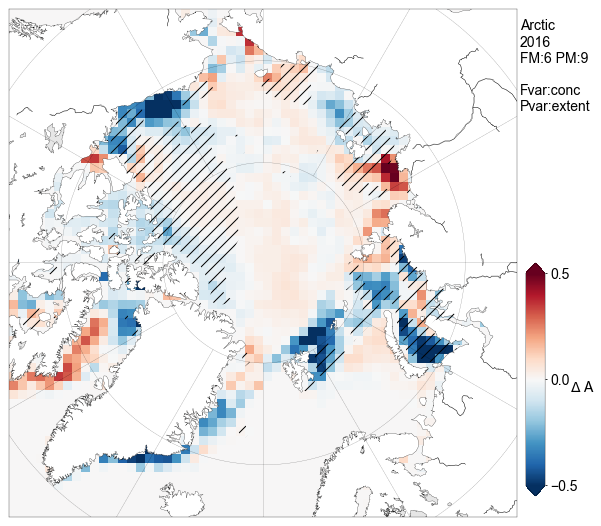

In [53]:
# plot forecast anomaly field that drove the forecast

minval=-0.5
maxval=0.5

if (hemStr=='N'):
    if ((region=='A')):
        regionOut='Alaska'
    else:
        regionOut='Arctic'
else:
    regionOut='Antarctic'

# Map projection
m = Basemap(projection='npstere',boundinglat=65,lon_0=0, resolution='l'  )

# Gridded coordinates

hemStr='N'
if (hemStr=='S'):
	poleStr='AA'
elif (hemStr=='N'):
	poleStr='A'

xpts=load(derivedDataPath+'IceConcA/'+concVersion+'/xpts100km'+poleStr)
ypts=load(derivedDataPath+'IceConcA/'+concVersion+'/ypts100km'+poleStr)
fig = figure(figsize=(9,9*0.8))
ax=gca()

im1 = m.contourf(xpts , ypts, rvalsDT,levels=[0.3, 0.8], colors='none', hatches=['//'], zorder=3)

im2 = m.pcolormesh(xpts, ypts, unweightedPredVarT,vmin=minval, vmax=maxval, cmap=cm.RdBu_r, shading='interp', zorder=2)
#im1 = m.pcolormesh(xpts , ypts, rvals, cmap=cm.cubehelix, vmin=minval, vmax=maxval,shading='flat', zorder=2)

m.fillcontinents(color='w',lake_color='0.9', zorder=2)
m.drawcoastlines(linewidth=0.25, zorder=5)
m.drawparallels(np.arange(90,-90,-10), linewidth = 0.25, zorder=3)
m.drawmeridians(np.arange(-180.,180.,30.), linewidth = 0.25, zorder=3)

label_str=r'$\Delta$ A'
cax = fig.add_axes([0.81, 0.05, 0.03, 0.45])
cbar = colorbar(im2,cax=cax, orientation='vertical', extend='both', use_gridspec=True)
cbar.set_label(label_str, labelpad=4, rotation=0)
cbar.set_ticks(np.linspace(minval, maxval, 3))
cbar.solids.set_rasterized(True)

#ax.annotate(varStr, xy=(0.5, 1.01),xycoords='axes fraction', horizontalalignment='center', verticalalignment='bottom', zorder=10)
ax.annotate(regionOut+'\n'+str(yearP)+'\nFM:'+str(fmonth)+' PM:'+str(pmonth)+'\n\nFvar:'+fvars[0]+'\nPvar:'+iceType, xy=(1.005, 0.98), xycoords='axes fraction', horizontalalignment='left', verticalalignment='top', rotation=0, zorder=10)

subplots_adjust(bottom=0.01, top=0.99, left=0.01, right=0.8)
plt.show()
#savefig(figpath+'anomaly'+varStr+iceType+'fm'+str(fmonth)+'pm'+str(pmonth)+'R'+str(region)+str(startYear)+str(yearT)+poleStr+'.png', dpi=300)
#close(fig)
